In [1]:
import math
import os
import warnings
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
def get_dataloader(
    config: Dict[str, Any]
) -> Tuple[BatchMetaDataLoader, BatchMetaDataLoader, BatchMetaDataLoader]:
    train_dataset = omniglot(
        folder=config["folder_name"],
        shots=config["num_shots"],
        # test_shots=1, # default = shots
        ways=config["num_ways"],
        shuffle=True,
        meta_train=True,
        download=config["download"],
    )
    train_dataloader = BatchMetaDataLoader(
        train_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1
    )

    val_dataset = omniglot(
        folder=config["folder_name"],
        shots=config["num_shots"],
        # test_shots=1, # default = shots
        ways=config["num_ways"],
        shuffle=True,
        meta_val=True,
        download=config["download"],
    )
    val_dataloader = BatchMetaDataLoader(
        val_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1
    )

    test_dataset = omniglot(
        folder=config["folder_name"],
        shots=config["num_shots"],
        # test_shots=1, # default = shots
        ways=config["num_ways"],
        shuffle=True,
        meta_test=True,
        download=config["download"],
    )
    test_dataloader = BatchMetaDataLoader(
        test_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1
    )
    return train_dataloader, val_dataloader, test_dataloader

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self, x_dim: int = 1, hid_dim: int = 64, z_dim: int = 64) -> None:
        super(EmbeddingNet, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(in_channels=x_dim, out_channels=hid_dim),
            self.conv_block(in_channels=hid_dim, out_channels=hid_dim),
            self.conv_block(in_channels=hid_dim, out_channels=hid_dim),
            self.conv_block(in_channels=hid_dim, out_channels=z_dim),
        )

    @classmethod
    def conv_block(cls, in_channels: int, out_channels: int) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        out = x.view(x.size(0), -1)
        return out

In [4]:
class CasualConv1d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        dilation: int = 1,
        groups: int = 1,
        bias: int = True,
    ) -> None:
        super(CasualConv1d, self).__init__()
        self.dilation = dilation
        padding = dilation * (kernel_size - 1)
        self.conv1d = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1d(x)
        return out[:, :, : -self.dilation]

In [5]:
class DenseBlock(nn.Module):
    def __init__(
        self, in_channels: int, dilation: int, filters: int, kernel_size: int = 2
    ) -> None:
        super(DenseBlock, self).__init__()
        self.causal_conv1 = CasualConv1d(
            in_channels, filters, kernel_size, dilation=dilation
        )
        self.causal_conv2 = CasualConv1d(
            in_channels, filters, kernel_size, dilation=dilation
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xf = self.causal_conv1(x)
        xg = self.causal_conv2(x)
        activations = torch.tanh(xf) * torch.sigmoid(xg)
        return torch.cat((x, activations), dim=1)

In [6]:
class TCBlock(nn.Module):
    def __init__(self, in_channels: int, seq_length: int, filters: int) -> None:
        super(TCBlock, self).__init__()
        self.dense_blocks = nn.ModuleList(
            [
                DenseBlock(in_channels + i * filters, 2 ** (i + 1), filters)
                for i in range(int(math.ceil(math.log(seq_length, 2))))
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.transpose(x, 1, 2)
        for block in self.dense_blocks:
            x = block(x)
        return torch.transpose(x, 1, 2)

In [7]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels: int, key_size: int, value_size: int) -> None:
        super(AttentionBlock, self).__init__()
        self.query_layer = nn.Linear(in_channels, key_size)
        self.keys_layer = nn.Linear(in_channels, key_size)
        self.values_layer = nn.Linear(in_channels, value_size)
        self.sqrt_key_size = math.sqrt(key_size)
        self.key_size = key_size

    @classmethod
    def causally_masked_softmax(
        cls, logits: torch.Tensor, key_size: int
    ) -> torch.Tensor:
        seq_len = logits.shape[1]
        mask = np.array([[i > j for i in range(seq_len)] for j in range(seq_len)])
        mask = torch.BoolTensor(mask).to(logits.get_device())

        logits = logits.data.masked_fill(mask, -float("inf"))
        return F.softmax(logits / math.sqrt(key_size), dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        keys = self.keys_layer(x)
        query = self.query_layer(x)
        logits = torch.bmm(query, torch.transpose(keys, 1, 2))

        probs = self.causally_masked_softmax(logits, self.key_size)
        values = self.values_layer(x)

        read = torch.bmm(probs, values)
        return torch.cat((x, read), dim=2)

In [8]:
class SNAIL(nn.Module):
    def __init__(self, num_ways: int, num_shots: int) -> None:
        super(SNAIL, self).__init__()
        self.num_ways, self.num_shots = num_ways, num_shots

        self.encoder = EmbeddingNet()
        num_channels = 64 + num_ways
        num_filters = int(math.ceil(math.log(num_ways * num_shots + 1, 2)))

        self.attention1 = AttentionBlock(num_channels, 64, 32)
        num_channels += 32
        self.tc1 = TCBlock(num_channels, num_ways * num_shots + 1, 128)
        num_channels += num_filters * 128

        self.attention2 = AttentionBlock(num_channels, 256, 128)
        num_channels += 128
        self.tc2 = TCBlock(num_channels, num_ways * num_shots + 1, 128)
        num_channels += num_filters * 128

        self.attention3 = AttentionBlock(num_channels, 512, 256)
        num_channels += 256
        self.fc = nn.Linear(num_channels, num_ways)

    def forward(self, x_seq: torch.Tensor, y_seq: torch.Tensor) -> torch.Tensor:
        x_emb = self.encoder(x_seq)
        batch_size = int(y_seq.size()[0] / (self.num_ways * self.num_shots + 1))

        last_idxs = [
            (i + 1) * (self.num_ways * self.num_shots + 1) - 1
            for i in range(batch_size)
        ]
        y_seq[last_idxs] = torch.Tensor(np.zeros((batch_size, y_seq.size()[1]))).to(
            y_seq.get_device()
        )

        x_cat = torch.cat((x_emb, y_seq), 1)
        x_view = x_cat.view((batch_size, self.num_ways * self.num_shots + 1, -1))

        x_att1 = self.attention1(x_view)
        x_tc1 = self.tc1(x_att1)

        x_att2 = self.attention2(x_tc1)
        x_tc2 = self.tc2(x_att2)

        x_att3 = self.attention3(x_tc2)
        x_out = self.fc(x_att3)
        return x_out

In [9]:
def generate_sequence(
    task_batch: Dict[str, List[torch.Tensor]],
    device: str,
    num_ways: int,
    num_shots: int,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    support_xs = task_batch["train"][0].to(device=device)
    support_ys = task_batch["train"][1].to(device=device)
    query_xs = task_batch["test"][0].to(device=device)
    query_ys = task_batch["test"][1].to(device=device)

    chosen_indices = torch.randint(query_xs.shape[1], size=(query_xs.shape[0],))
    chosen_query_xs = query_xs[
        torch.arange(query_xs.shape[0]), chosen_indices, :, :, :
    ].unsqueeze(1)
    chosen_query_ys = query_ys[
        torch.arange(query_ys.shape[0]), chosen_indices
    ].unsqueeze(1)

    x_seq = torch.cat((support_xs, chosen_query_xs), dim=1).reshape(
        (-1, *support_xs.shape[2:])
    )
    y_seq = torch.cat((support_ys, chosen_query_ys), dim=1).reshape(
        (-1, *support_ys.shape[2:])
    )

    y_seq_onehot = F.one_hot(y_seq).float()

    query_y = y_seq[:: (num_ways * num_shots + 1)].long()
    return x_seq, y_seq_onehot, query_y

In [10]:
def train_snail(
    num_ways: int,
    num_shots: int,
    device: str,
    task_batch: Dict[str, List[torch.Tensor]],
    model: SNAIL,
    criterion: nn.CrossEntropyLoss,
    optimizer: torch.optim.Adam,
) -> Tuple[float, float]:
    model.train()

    x_seq, y_seq, query_y = generate_sequence(
        task_batch=task_batch, device=device, num_ways=num_ways, num_shots=num_shots
    )
    x_seq = x_seq.to(device=device)
    y_seq = y_seq.to(device=device)
    query_y = query_y.to(device=device)

    query_prob = model(x_seq, y_seq)[:, -1, :]
    loss = criterion(query_prob, query_y)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        _, query_preds = query_prob.max(1)
        accuracy = torch.eq(query_preds, query_y).float().mean()
    return accuracy.item(), loss.item()

In [11]:
def test_snail(
    num_ways: int,
    num_shots: int,
    device: str,
    task_batch: Dict[str, List[torch.Tensor]],
    model: SNAIL,
    criterion: nn.CrossEntropyLoss,
) -> Tuple[float, float]:
    model.eval()

    x_seq, y_seq, query_y = generate_sequence(
        task_batch=task_batch, device=device, num_ways=num_ways, num_shots=num_shots
    )
    x_seq = x_seq.to(device=device)
    y_seq = y_seq.to(device=device)
    query_y = query_y.to(device=device)

    query_prob = model(x_seq, y_seq)[:, -1, :]
    loss = criterion(query_prob, query_y)

    with torch.no_grad():
        _, query_preds = query_prob.max(1)
        accuracy = torch.eq(query_preds, query_y).float().mean()
    return accuracy.item(), loss.item()

In [12]:
def save_model(output_folder: str, model: SNAIL, title: str) -> None:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
    filename = os.path.join(output_folder, title)

    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("Model is saved in", filename)


def load_model(output_folder: str, model: SNAIL, title: str) -> None:
    filename = os.path.join(output_folder, title)
    model.load_state_dict(torch.load(filename))
    print("Model is loaded")

In [13]:
def print_graph(
    train_accuracies: List[float],
    val_accuracies: List[float],
    train_losses: List[float],
    val_losses: List[float],
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_accuracies, label="train_acc")
    axs[0].plot(val_accuracies, label="test_acc")
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_losses, label="train_loss")
    axs[1].plot(val_losses, label="test_loss")
    axs[1].set_title("Loss")
    axs[1].legend()

    fig.show()

In [14]:
config = {
    "folder_name": "dataset",
    "download": True,
    "num_shots": 1,
    "num_ways": 5,
    "output_folder": "saved_model",
    "task_batch_size": 32,  # 필수
    "num_task_batch_train": 600,  # 필수
    "num_task_batch_test": 200,  # 필수
    "device": "cuda",  # 필수
}

train_dataloader, val_dataloader, test_dataloader = get_dataloader(config)

model = SNAIL(num_ways=config["num_ways"], num_shots=config["num_shots"]).to(
    device=config["device"]
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

100%|██████████| 600/600 [01:20<00:00,  7.43it/s, train_accuracy=1.0000, train_loss=0.0290, val_accuracy=1.0000, val_loss=0.0299]


Model is saved in saved_model/snail.th


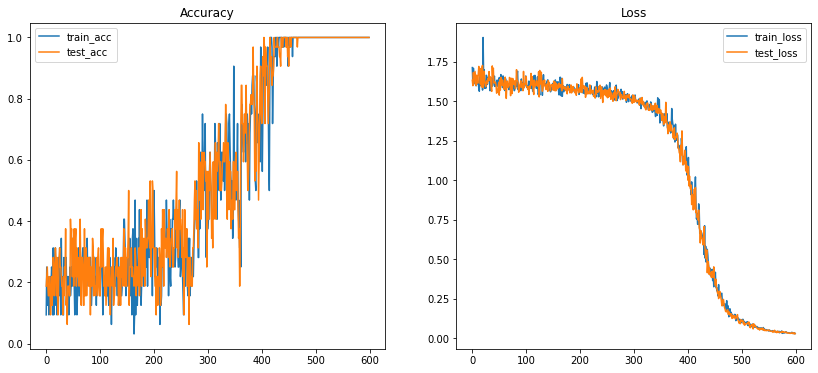

In [15]:
# 메타-트레이닝
with tqdm(
    zip(train_dataloader, val_dataloader), total=config["num_task_batch_train"]
) as pbar:
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= config["num_task_batch_train"]:
            break

        train_accuracy, train_loss = train_snail(
            num_ways=config["num_ways"],
            num_shots=config["num_shots"],
            device=config["device"],
            task_batch=train_batch,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
        )
        val_accuracy, val_loss = test_snail(
            num_ways=config["num_ways"],
            num_shots=config["num_shots"],
            device=config["device"],
            task_batch=val_batch,
            model=model,
            criterion=criterion,
        )

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(
            train_accuracy="{0:.4f}".format(train_accuracy),
            val_accuracy="{0:.4f}".format(val_accuracy),
            train_loss="{0:.4f}".format(train_loss),
            val_loss="{0:.4f}".format(val_loss),
        )

    # 모델 저장하기
    save_model(output_folder=config["output_folder"], model=model, title="snail.th")

    print_graph(
        train_accuracies=train_accuracies,
        val_accuracies=val_accuracies,
        train_losses=train_losses,
        val_losses=val_losses,
    )

In [16]:
# 모델 불러오기
load_model(output_folder=config["output_folder"], model=model, title="snail.th")

# 메타-테스팅
with tqdm(test_dataloader, total=config["num_task_batch_test"]) as pbar:
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0

    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= config["num_task_batch_test"]:
            break

        test_accuracy, test_loss = test_snail(
            num_ways=config["num_ways"],
            num_shots=config["num_shots"],
            device=config["device"],
            task_batch=test_batch,
            model=model,
            criterion=criterion,
        )

        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss
        pbar.set_postfix(
            test_accuracy="{0:.4f}".format(sum_test_accuracies / (task_batch_idx + 1)),
            test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1)),
        )

Model is loaded


100%|██████████| 200/200 [00:27<00:00,  7.30it/s, test_accuracy=1.0000, test_loss=0.0301]


: 